In [62]:
from astropy.io import fits
import pandas as pd
import fitdecode
from datetime import datetime, timedelta
from typing import Dict, Optional, Union
import os

# list of files in './Fit Files' directory
files = os.listdir('./Fit Files')

POINTS_COLUMN_NAMES = ['latitude', 'longitude', 'lap', 'altitude', 'timestamp', 'heart_rate', 'cadence', 'speed']
LAPS_COLUMN_NAMES = ['number', 'start_time', 'total_distance', 'total_elapsed_time',
                     'max_speed', 'max_heart_rate', 'avg_heart_rate']

In [65]:

def get_fit_point_data(frame: fitdecode.records.FitDataMessage) -> Optional[Dict[str, Union[float, int, str, datetime]]]:
    """Extract some data from an FIT frame representing a track point
    and return it as a dict.
    """
    
    data: Dict[str, Union[float, int, str, datetime]] = {}
    
    if not (frame.has_field('position_lat') and frame.has_field('position_long')):
        # Frame does not have any latitude or longitude data. We will ignore these frames in order to keep things
        # simple, as we did when parsing the TCX file.
        return None
    else:
        data['latitude'] = frame.get_value('position_lat') / ((2**32) / 360) if frame.get_value('position_lat') else None
        data['longitude'] = frame.get_value('position_long') / ((2**32) / 360) if frame.get_value('position_long') else None
    
    for field in POINTS_COLUMN_NAMES[3:]:
        if frame.has_field(field):
            data[field] = frame.get_value(field)
    
    return data
def get_fit_lap_data(frame: fitdecode.records.FitDataMessage) -> Dict[str, Union[float, datetime, timedelta, int]]:
    """Extract some data from a FIT frame representing a lap and return
    it as a dict.
    """
    
    data: Dict[str, Union[float, datetime, timedelta, int]] = {}
    
    for field in LAPS_COLUMN_NAMES[1:]:  # Exclude 'number' (lap number) because we don't get that
                                        # from the data but rather count it ourselves
        if frame.has_field(field):
            data[field] = frame.get_value(field)
    
    return data

In [60]:

# convert the FIT file to a CSV file
def load_fit_file(fit_file_path: str) -> pd.DataFrame:
    with fitdecode.FitReader(fit_file_path) as fit_file:
        points_data = []
        laps_data = []
        lap_no = 1
        for frame in fit_file:
            if isinstance(frame, fitdecode.records.FitDataMessage):
                if frame.name == 'record':
                    single_point_data = get_fit_point_data(frame)
                    if single_point_data is not None:
                        single_point_data['lap'] = lap_no
                        points_data.append(single_point_data)
                elif frame.name == 'lap':
                    single_lap_data = get_fit_lap_data(frame)
                    single_lap_data['number'] = lap_no
                    laps_data.append(single_lap_data)
                    lap_no += 1
        df = pd.DataFrame(points_data)
    return df

In [67]:
df = pd.DataFrame()
for file in files:
    if file.endswith('.fit'):
        print(f'Processing {file}')
        df_ = load_fit_file(f'./Fit Files/{file}')
        df_['file'] = file
        df = pd.concat([df, df_], axis=0)
df # latitude	longitude	altitude	timestamp	heart_rate	cadence	speed	lap	file


Processing i54557414_Elsene_Running.fit
Processing i47043425_Elsene_Running.fit
Processing i50833871_Dolce_La_hulpe.fit
Processing i51102651_Elsene_Running.fit
Processing i48218172_Jetpack_Run.fit
Processing 11821793613_Running_20240706.fit
Processing i52725157_Elsene_Running.fit
Processing i48465955_Elsene_Running.fit
Processing i49150779_Rochebrune_Running.fit
Processing i47988812_Elsene_Running.fit
Processing i45625574_Cardio_.fit
Processing i52364000_Elsene_Running.fit
Processing i54779377_Elsene_Running.fit
Processing 11782745891_Running_20240701.fit
Processing 11872164266_Running_20240712.fit
Processing i46183643_Elsene_Running.fit
Processing i44755170_Etterbeek_Running.fit
Processing i45061061_Elsene_Running.fit
Processing i47611460_Jetpack_Lunch_Run_.fit
Processing i46021153_Elsene_Running.fit
Processing i44661377_Elsene_Running.fit
Processing i45476927_Elsene_Running.fit
Processing i50475502_Jetpack_Run.fit
Processing i44532205_Afternoon_Run.fit
Processing i54109561_Brussels_R

,latitude,longitude,altitude,timestamp,heart_rate,cadence,speed,lap,file
0,50.816315,4.386753,101.0,2024-11-07 17:09:34+00:00,105.0,88,0.000,1,i54557414_Elsene_Running.fit
1,50.816395,4.386613,100.0,2024-11-07 17:09:35+00:00,106.0,88,0.000,1,i54557414_Elsene_Running.fit
2,50.816414,4.386529,100.0,2024-11-07 17:09:36+00:00,107.0,88,0.000,1,i54557414_Elsene_Running.fit
3,50.816452,4.386597,100.0,2024-11-07 17:09:37+00:00,107.0,88,0.000,1,i54557414_Elsene_Running.fit
4,50.816479,4.386523,100.0,2024-11-07 17:09:38+00:00,108.0,88,1.521,1,i54557414_Elsene_Running.fit
...,...,...,...,...,...,...,...,...,...
5339,50.815895,4.381301,101.0,2024-10-14 18:22:56+00:00,168.0,84,3.247,1,i52274692_Elsene_Running.fit
5340,50.815918,4.381330,101.0,2024-10-14 18:22:57+00:00,167.0,84,3.247,1,i52274692_Elsene_Running.fit
5341,50.815933,4.381359,101.0,2024-10-14 18:22:58+00:00,167.0,84,3.247,1,i52274692_Elsene_Running.fit
5342,50.815948,4.381384,101.0,2024-10-14 18:22:59+00:00,167.0,84,3.247,1,i52274692_Elsene_Running.fit


In [74]:
df.to_csv('observable/src/data/export.csv', index=False)

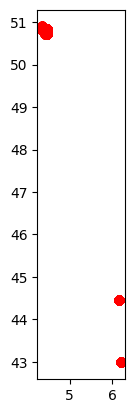

In [71]:
# plot latitude and longitude on a map
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

